# Audio Spectrogram Transformer (AST) for Music Emotion Recognition

## Overview
This notebook trains an Audio Spectrogram Transformer (AST) model to predict **valence** and **arousal** from music using the **DEAM (Database for Emotional Analysis of Music)** dataset.

### What is AST?
Audio Spectrogram Transformer is a Vision Transformer (ViT) architecture adapted for audio classification. It:
- Converts audio to mel-spectrograms
- Splits spectrograms into patches
- Uses self-attention to learn temporal and spectral patterns
- Predicts emotional dimensions (valence and arousal)

### Dataset Requirements
This notebook expects the DEAM dataset to be available as a Kaggle dataset. 
**Dataset structure:**
```
/kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/
├── DEAM_audio/
│   └── MEMD_audio/  (contains .mp3 files)
└── DEAM_Annotations/
    └── annotations/
        └── annotations averaged per song/
            └── song_level/
                ├── static_annotations_averaged_songs_1_2000.csv
                └── static_annotations_averaged_songs_2000_2058.csv
```

### Training Configuration
- **Model**: Vision Transformer adapted for audio
- **Input**: Mel-spectrograms (128 mel bins × 432 time steps)
- **Output**: Valence and Arousal predictions (1-9 scale)
- **Loss**: Mean Squared Error (MSE)
- **Metrics**: MSE, MAE, Concordance Correlation Coefficient (CCC)

In [24]:
# ============================================================================
# IMPORTS AND ENVIRONMENT SETUP
# ============================================================================

import os
import warnings
warnings.filterwarnings('ignore')

# Check Kaggle environment
print("Kaggle Environment Check:")
print(f"Is Kaggle: {os.path.exists('/kaggle')}")
print(f"GPU Available: {os.path.exists('/dev/nvidia0')}")
print()

# Core libraries
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, SequentialSampler

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Kaggle Environment Check:
Is Kaggle: True
GPU Available: True

All imports successful!
PyTorch version: 2.6.0+cu124
Librosa version: 0.11.0
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


## 1. Configuration and Paths

**Important for Kaggle Users:**
- Make sure you've added the DEAM dataset to your notebook
- The dataset should be named: `deam-mediaeval-dataset-emotional-analysis-in-music`
- Go to "Add Data" → Search for "DEAM" → Add to notebook

In [25]:
# ============================================================================
# CONFIGURATION AND PATHS FOR KAGGLE
# ============================================================================

# Kaggle paths - using the main DEAM dataset
DATASET_PATH = '/kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music'
AUDIO_DIR = os.path.join(DATASET_PATH, 'DEAM_audio', 'MEMD_audio')
ANNOTATIONS_DIR = os.path.join(DATASET_PATH, 'DEAM_Annotations', 'annotations', 
                               'annotations averaged per song', 'song_level')

# Output paths (Kaggle working directory)
OUTPUT_DIR = '/kaggle/working'
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'best_ast_model.pth')

# Annotation file paths (inside the main DEAM dataset)
STATIC_CSV_1_2000 = os.path.join(ANNOTATIONS_DIR, 'static_annotations_averaged_songs_1_2000.csv')
STATIC_CSV_2000_2058 = os.path.join(ANNOTATIONS_DIR, 'static_annotations_averaged_songs_2000_2058.csv')

# Hyperparameters
SEGMENT_LENGTH = 5      # seconds per audio segment
SAMPLE_RATE = 44100     # Hz
N_MELS = 128            # Mel frequency bins
TARGET_TIME_STEPS = 432 # Fixed width for padding (divisible by patch_size)
PATCH_SIZE = 16         # Patch size for transformer
EMBED_DIM = 256         # Embedding dimension
NUM_HEADS = 4           # Number of attention heads
NUM_LAYERS = 4          # Number of transformer layers
DROPOUT = 0.1
BATCH_SIZE = 16         # Increased for GPU
NUM_EPOCHS = 2         # More epochs for better convergence
LEARNING_RATE = 1e-4

# Split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

print("="*80)
print("AST Model Training - Kaggle Environment")
print("="*80)
print(f"Dataset Path: {DATASET_PATH}")
print(f"Audio Directory: {AUDIO_DIR}")
print(f"Annotations Directory: {ANNOTATIONS_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")
print("\nExpected Kaggle dataset structure:")
print("  /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/")
print("    ├── DEAM_audio/")
print("    │   └── MEMD_audio/  (audio files)")
print("    ├── DEAM_Annotations/")
print("    │   └── annotations/")
print("    │       └── annotations averaged per song/")
print("    │           └── song_level/  (CSV files)")
print("    └── features/")
print("="*80)

AST Model Training - Kaggle Environment
Dataset Path: /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music
Audio Directory: /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/DEAM_audio/MEMD_audio
Annotations Directory: /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/DEAM_Annotations/annotations/annotations averaged per song/song_level
Output Directory: /kaggle/working
Model Save Path: /kaggle/working/best_ast_model.pth

Expected Kaggle dataset structure:
  /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/
    ├── DEAM_audio/
    │   └── MEMD_audio/  (audio files)
    ├── DEAM_Annotations/
    │   └── annotations/
    │       └── annotations averaged per song/
    │           └── song_level/  (CSV files)
    └── features/


## 2. Data Loading and Exploration

In [26]:
# Verify paths exist
assert os.path.exists(AUDIO_DIR), f"Audio directory not found: {AUDIO_DIR}"
assert os.path.exists(STATIC_CSV_1_2000), f"Annotations file not found: {STATIC_CSV_1_2000}"
assert os.path.exists(STATIC_CSV_2000_2058), f"Annotations file not found: {STATIC_CSV_2000_2058}"

print("✓ All paths verified!")

# Load and combine annotation files
print("\nLoading annotation files...")
df1 = pd.read_csv(STATIC_CSV_1_2000)
df2 = pd.read_csv(STATIC_CSV_2000_2058)
df_annotations = pd.concat([df1, df2], axis=0, ignore_index=True)

# Strip whitespace from column names (important!)
df_annotations.columns = df_annotations.columns.str.strip()

print(f"Loaded {len(df_annotations)} song annotations")
print(f"Columns: {df_annotations.columns.tolist()}")
print(f"\nSample data:")
df_annotations.head()

✓ All paths verified!

Loading annotation files...
Loaded 1802 song annotations
Columns: ['song_id', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std', 'valence_ max_mean', 'valence_max_std', 'valence_min_mean', 'valence_min_std', 'arousal_max_mean', 'arousal_max_std', 'arousal_min_mean', 'arousal_min_std']

Sample data:


,song_id,valence_mean,valence_std,arousal_mean,arousal_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std
0,2,3.1,0.94,3.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3.5,1.75,3.3,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,5.7,1.42,5.5,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,4.4,2.01,5.3,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,5.8,1.47,6.4,1.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Verify audio files exist
print("Verifying audio files...")
available_songs = []
missing_songs = []

for _, row in df_annotations.iterrows():
    song_id = int(row['song_id'])
    audio_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")
    if os.path.exists(audio_path):
        available_songs.append(song_id)
    else:
        missing_songs.append(song_id)

print(f"Available audio files: {len(available_songs)}")
print(f"Missing audio files: {len(missing_songs)}")
if len(missing_songs) > 0 and len(missing_songs) < 20:
    print(f"Missing song IDs: {missing_songs}")

# Filter to only available songs
df_annotations = df_annotations[df_annotations['song_id'].isin(available_songs)].reset_index(drop=True)
print(f"Final dataset size: {len(df_annotations)} songs")

Verifying audio files...
Available audio files: 1802
Missing audio files: 0
Final dataset size: 1802 songs


## 3. PyTorch Dataset Class

This custom dataset class:
1. Loads audio files and splits them into 5-second segments
2. Computes mel-spectrograms for each segment
3. Pads/truncates to fixed width (432 time steps)
4. Optionally applies SpecAugment (data augmentation)
5. Returns (spectrogram, [valence, arousal]) pairs

In [28]:
class DEAMSpectrogramDataset(Dataset):
    """
    PyTorch Dataset for DEAM audio with mel-spectrogram features.
    """
    def __init__(self, df_annotations, audio_dir, segment_length=5, sr=44100, 
                 target_time_steps=432, use_aug=False):
        self.df = df_annotations.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.segment_length = segment_length
        self.sr = sr
        self.segment_samples = segment_length * sr
        self.target_time_steps = target_time_steps
        self.use_aug = use_aug
        
        # Pre-compute all valid segment indices
        self.segment_indices = []
        
        print(f"Initializing dataset (aug={'ON' if use_aug else 'OFF'})...")
        for song_idx in range(len(self.df)):
            song_id = int(self.df.iloc[song_idx]['song_id'])
            audio_path = os.path.join(self.audio_dir, f"{song_id}.mp3")
            
            try:
                y, _ = librosa.load(audio_path, sr=self.sr, mono=True)
                num_segments = len(y) // self.segment_samples
                
                for seg_idx in range(num_segments):
                    self.segment_indices.append((song_idx, seg_idx))
                    
            except Exception as e:
                print(f"Warning: Error loading song {song_id}: {e}")
                continue
        
        print(f"Dataset ready: {len(self.segment_indices)} segments")
    
    def __len__(self):
        return len(self.segment_indices)
    
    def __getitem__(self, idx):
        song_idx, seg_idx = self.segment_indices[idx]
        song_id = int(self.df.iloc[song_idx]['song_id'])
        
        # Load audio
        audio_path = os.path.join(self.audio_dir, f"{song_id}.mp3")
        y, _ = librosa.load(audio_path, sr=self.sr, mono=True)
        
        # Extract segment
        start = seg_idx * self.segment_samples
        segment = y[start:start + self.segment_samples]
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=segment, sr=self.sr, n_mels=N_MELS, n_fft=2048, hop_length=512
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Pad or truncate to target width
        if mel_spec_db.shape[1] < self.target_time_steps:
            pad_width = self.target_time_steps - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_spec_db.shape[1] > self.target_time_steps:
            mel_spec_db = mel_spec_db[:, :self.target_time_steps]
        
        # Convert to tensor
        mel_spec_db = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0)
        
        # SpecAugment (optional)
        if self.use_aug:
            freq_mask_param = 10
            if N_MELS > freq_mask_param:
                freq_mask_start = torch.randint(0, N_MELS - freq_mask_param, (1,)).item()
                mel_spec_db[:, freq_mask_start:freq_mask_start + freq_mask_param, :] = 0
            
            time_mask_param = 20
            if self.target_time_steps > time_mask_param:
                time_mask_start = torch.randint(0, self.target_time_steps - time_mask_param, (1,)).item()
                mel_spec_db[:, :, time_mask_start:time_mask_start + time_mask_param] = 0
        
        # Get labels
        label = torch.tensor([
            self.df.iloc[song_idx]['valence_mean'], 
            self.df.iloc[song_idx]['arousal_mean']
        ], dtype=torch.float32)
        
        return mel_spec_db, label

print("✓ Dataset class defined")

✓ Dataset class defined


## 4. Data Preparation and Splitting

In [29]:
# Create initial dataset (no augmentation for computing statistics)
full_dataset = DEAMSpectrogramDataset(
    df_annotations, AUDIO_DIR, 
    target_time_steps=TARGET_TIME_STEPS, 
    use_aug=False
)

# Split into train/val/test
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = int(VAL_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

print(f"\nDataset splits:")
print(f"  Train: {train_size} ({100*TRAIN_RATIO:.0f}%)")
print(f"  Val:   {val_size} ({100*VAL_RATIO:.0f}%)")
print(f"  Test:  {test_size} ({100*TEST_RATIO:.0f}%)")

# Random split
train_dataset_temp, val_dataset_temp, test_dataset_temp = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

Initializing dataset (aug=OFF)...
Dataset ready: 18373 segments

Dataset splits:
  Train: 14698 (80%)
  Val:   1837 (10%)
  Test:  1838 (10%)


In [30]:
# Compute normalization statistics from training set
print("Computing normalization statistics...")
train_specs_list = []
max_samples = min(1000, len(train_dataset_temp))

for idx in list(train_dataset_temp.indices)[:max_samples]:
    spec, _ = full_dataset[idx]
    train_specs_list.append(spec)

train_specs = torch.cat(train_specs_list, dim=0)
global_mean = train_specs.mean()
global_std = train_specs.std()

print(f"Global mean: {global_mean:.4f}")
print(f"Global std:  {global_std:.4f}")

Computing normalization statistics...
Global mean: -48.0638
Global std:  19.7498


In [31]:
# Create final datasets with augmentation
train_indices = train_dataset_temp.indices
val_indices = val_dataset_temp.indices
test_indices = test_dataset_temp.indices

train_dataset = DEAMSpectrogramDataset(
    df_annotations, AUDIO_DIR, 
    target_time_steps=TARGET_TIME_STEPS, 
    use_aug=True  # Enable augmentation for training
)

val_dataset = DEAMSpectrogramDataset(
    df_annotations, AUDIO_DIR, 
    target_time_steps=TARGET_TIME_STEPS, 
    use_aug=False
)

test_dataset = DEAMSpectrogramDataset(
    df_annotations, AUDIO_DIR, 
    target_time_steps=TARGET_TIME_STEPS, 
    use_aug=False
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    sampler=SubsetRandomSampler(train_indices),
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    sampler=SequentialSampler(val_indices),
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    sampler=SequentialSampler(test_indices),
    num_workers=2, pin_memory=True
)

print("✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

Initializing dataset (aug=ON)...
Dataset ready: 18373 segments
Initializing dataset (aug=OFF)...
Dataset ready: 18373 segments
Initializing dataset (aug=OFF)...
Dataset ready: 18373 segments
✓ DataLoaders created
  Train batches: 919
  Val batches:   115
  Test batches:  115


## 5. Model Architecture (Audio Spectrogram Transformer)

The AST model architecture:
- **Patch Embedding**: Splits spectrogram into 16×16 patches using Conv2D
- **Positional Encoding**: Learnable position embeddings
- **CLS Token**: Special token for classification (like BERT/ViT)
- **Transformer Encoder**: Multi-head self-attention layers
- **Regression Head**: MLP to predict valence and arousal

In [32]:
class SpectrogramTransformer(nn.Module):
    """Audio Spectrogram Transformer for emotion recognition."""
    
    def __init__(self, input_height=128, input_width=432, patch_size=16, 
                 embed_dim=256, num_heads=4, num_layers=4, dropout=0.1):
        super().__init__()
        
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Calculate number of patches
        self.num_patches_h = input_height // patch_size  # 8
        self.num_patches_w = input_width // patch_size   # 27
        num_patches = self.num_patches_h * self.num_patches_w  # 216
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout, activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Regression head
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)  # valence, arousal
        )
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.kaiming_normal_(self.patch_embed.weight, mode='fan_out', nonlinearity='relu')
        if self.patch_embed.bias is not None:
            nn.init.constant_(self.patch_embed.bias, 0)
    
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        
        # Prepend CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embeddings
        x = x + self.pos_embed
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # Extract CLS token
        cls_output = x[:, 0]
        
        # Regression head
        predictions = self.head(cls_output)
        
        return predictions

print("✓ Model class defined")

✓ Model class defined


In [33]:
# Initialize model
model = SpectrogramTransformer(
    input_height=N_MELS,
    input_width=TARGET_TIME_STEPS,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Device: cuda
Total parameters: 3,314,306
Trainable parameters: 3,314,306


## 6. Training Setup and Metrics

In [34]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance Correlation Coefficient for evaluating agreement."""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    covariance = np.cov(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    denominator = np.sqrt(var_true * var_pred)
    rho = covariance / denominator if denominator > 0 else 0
    
    numerator = 2 * rho * np.sqrt(var_true) * np.sqrt(var_pred)
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
    ccc = numerator / denominator if denominator > 0 else 0
    
    return ccc

print("✓ Training setup complete")
print(f"Loss: MSELoss")
print(f"Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"Scheduler: CosineAnnealingLR")

✓ Training setup complete
Loss: MSELoss
Optimizer: AdamW (lr=0.0001)
Scheduler: CosineAnnealingLR


## 7. Training Loop

This will take some time depending on your GPU. On Kaggle with GPU enabled, expect ~30-60 minutes for 15 epochs.

In [35]:
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("="*80)
print("STARTING TRAINING")
print("="*80)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training
    model.train()
    train_loss = 0
    train_batches = 0
    
    for batch_idx, (specs, labels) in enumerate(train_loader):
        # Normalize
        specs = (specs - global_mean) / global_std
        specs, labels = specs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    train_loss /= train_batches
    train_losses.append(train_loss)
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f}, LR: {current_lr:.6f}")
    
    # Validation
    model.eval()
    val_loss = 0
    val_batches = 0
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for specs, labels in val_loader:
            specs = (specs - global_mean) / global_std
            specs, labels = specs.to(device), labels.to(device)
            
            outputs = model(specs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_batches += 1
            
            val_preds.append(outputs.cpu().numpy())
            val_true.append(labels.cpu().numpy())
    
    val_loss /= val_batches
    val_losses.append(val_loss)
    
    # Metrics
    val_preds = np.vstack(val_preds)
    val_true = np.vstack(val_true)
    
    mse_valence = mean_squared_error(val_true[:, 0], val_preds[:, 0])
    mse_arousal = mean_squared_error(val_true[:, 1], val_preds[:, 1])
    ccc_valence = concordance_correlation_coefficient(val_true[:, 0], val_preds[:, 0])
    ccc_arousal = concordance_correlation_coefficient(val_true[:, 1], val_preds[:, 1])
    
    print(f"Val Loss: {val_loss:.4f}")
    print(f"  Valence - MSE: {mse_valence:.4f}, CCC: {ccc_valence:.4f}")
    print(f"  Arousal - MSE: {mse_arousal:.4f}, CCC: {ccc_arousal:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'global_mean': global_mean,
            'global_std': global_std,
        }, MODEL_SAVE_PATH)
        print(f"  ✓ New best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Best validation loss: {best_val_loss:.4f}")

STARTING TRAINING

Epoch 1/2
----------------------------------------
  Batch 50/919, Loss: 1.5602
  Batch 100/919, Loss: 1.3222
  Batch 150/919, Loss: 1.0509
  Batch 200/919, Loss: 0.9911
  Batch 250/919, Loss: 1.5636
  Batch 300/919, Loss: 0.9328
  Batch 350/919, Loss: 1.2188
  Batch 400/919, Loss: 1.2203
  Batch 450/919, Loss: 0.8378
  Batch 500/919, Loss: 0.9248
  Batch 550/919, Loss: 0.8829
  Batch 600/919, Loss: 1.3420
  Batch 650/919, Loss: 1.0974
  Batch 700/919, Loss: 1.3978
  Batch 750/919, Loss: 0.7693
  Batch 800/919, Loss: 0.9431
  Batch 850/919, Loss: 1.3611
  Batch 900/919, Loss: 0.6788
Train Loss: 1.4215, LR: 0.000050
Val Loss: 1.1168
  Valence - MSE: 0.8937, CCC: 0.6291
  Arousal - MSE: 1.3414, CCC: 0.4176
  ✓ New best model saved! (Val Loss: 1.1168)

Epoch 2/2
----------------------------------------
  Batch 50/919, Loss: 1.3459
  Batch 100/919, Loss: 1.0890
  Batch 150/919, Loss: 1.1375
  Batch 200/919, Loss: 0.7474
  Batch 250/919, Loss: 1.7252
  Batch 300/919, Loss

## 8. Test Set Evaluation

In [36]:
# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_preds = []
test_true = []

print("Evaluating on test set...")
with torch.no_grad():
    for specs, labels in test_loader:
        specs = (specs - global_mean) / global_std
        specs, labels = specs.to(device), labels.to(device)
        
        outputs = model(specs)
        test_preds.append(outputs.cpu().numpy())
        test_true.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_true = np.vstack(test_true)

# Compute metrics
test_mse_valence = mean_squared_error(test_true[:, 0], test_preds[:, 0])
test_mse_arousal = mean_squared_error(test_true[:, 1], test_preds[:, 1])
test_mae_valence = mean_absolute_error(test_true[:, 0], test_preds[:, 0])
test_mae_arousal = mean_absolute_error(test_true[:, 1], test_preds[:, 1])
test_ccc_valence = concordance_correlation_coefficient(test_true[:, 0], test_preds[:, 0])
test_ccc_arousal = concordance_correlation_coefficient(test_true[:, 1], test_preds[:, 1])

print("\n" + "="*80)
print("FINAL TEST RESULTS")
print("="*80)
print(f"Valence - MSE: {test_mse_valence:.4f}, MAE: {test_mae_valence:.4f}, CCC: {test_ccc_valence:.4f}")
print(f"Arousal - MSE: {test_mse_arousal:.4f}, MAE: {test_mae_arousal:.4f}, CCC: {test_ccc_arousal:.4f}")
print("="*80)

Evaluating on test set...

FINAL TEST RESULTS
Valence - MSE: 0.8932, MAE: 0.7576, CCC: 0.6294
Arousal - MSE: 1.3420, MAE: 0.9422, CCC: 0.4173


## 9. Visualizations

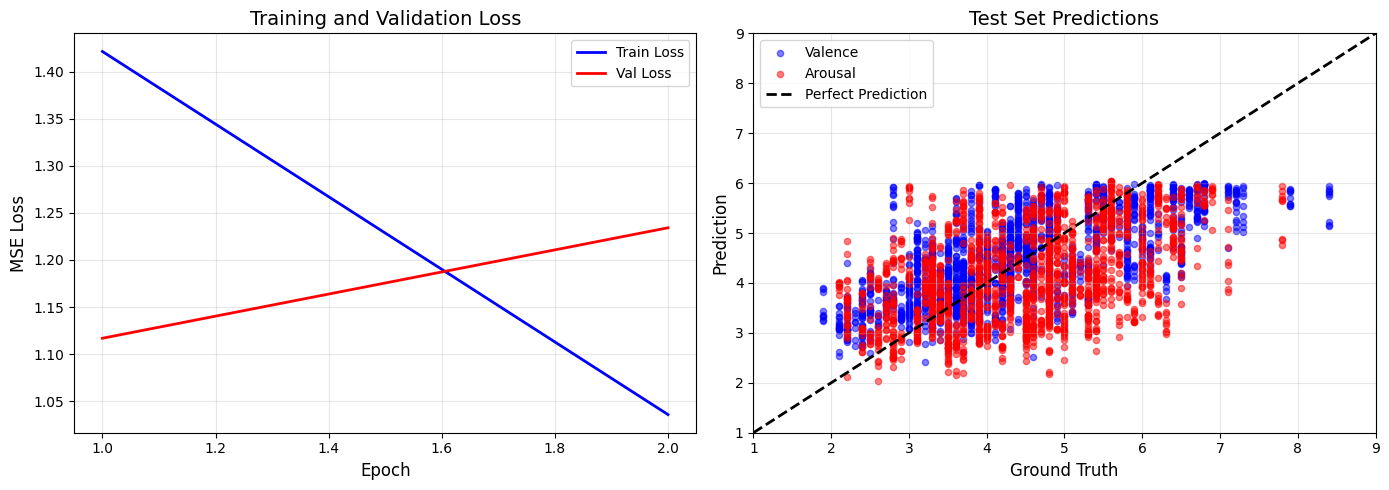

✓ Training curves saved


In [37]:
# Plot 1: Training curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, 'r-', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Ground Truth
plt.subplot(1, 2, 2)
plt.scatter(test_true[:, 0], test_preds[:, 0], alpha=0.5, label='Valence', s=20, c='blue')
plt.scatter(test_true[:, 1], test_preds[:, 1], alpha=0.5, label='Arousal', s=20, c='red')
plt.plot([1, 9], [1, 9], 'k--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Ground Truth', fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Test Set Predictions', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(1, 9)
plt.ylim(1, 9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

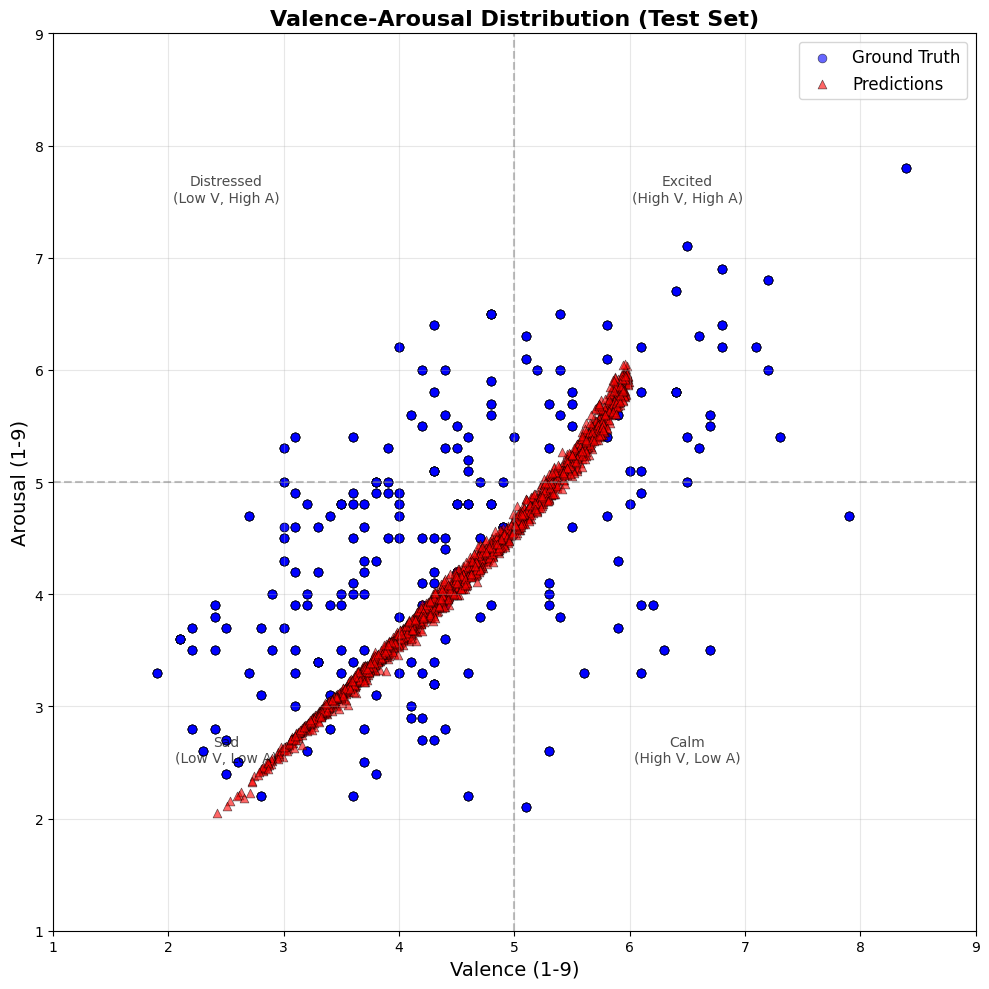

✓ Valence-Arousal plot saved


In [38]:
# Plot: Valence-Arousal Distribution
plt.figure(figsize=(10, 10))
plt.scatter(test_true[:, 0], test_true[:, 1], alpha=0.6, c='blue', 
            label='Ground Truth', s=40, edgecolors='black', linewidth=0.5)
plt.scatter(test_preds[:, 0], test_preds[:, 1], alpha=0.6, c='red', 
            label='Predictions', s=40, edgecolors='black', linewidth=0.5, marker='^')
plt.xlabel('Valence (1-9)', fontsize=14)
plt.ylabel('Arousal (1-9)', fontsize=14)
plt.title('Valence-Arousal Distribution (Test Set)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(1, 9)
plt.ylim(1, 9)

# Add quadrant labels
plt.axhline(y=5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=5, color='gray', linestyle='--', alpha=0.5)
plt.text(2.5, 7.5, 'Distressed\n(Low V, High A)', ha='center', fontsize=10, alpha=0.7)
plt.text(6.5, 7.5, 'Excited\n(High V, High A)', ha='center', fontsize=10, alpha=0.7)
plt.text(2.5, 2.5, 'Sad\n(Low V, Low A)', ha='center', fontsize=10, alpha=0.7)
plt.text(6.5, 2.5, 'Calm\n(High V, Low A)', ha='center', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'valence_arousal_distribution.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Valence-Arousal plot saved")

## 10. Summary and Next Steps

### What We Accomplished
✅ Loaded and preprocessed the DEAM dataset  
✅ Created mel-spectrogram features from audio  
✅ Built an Audio Spectrogram Transformer model  
✅ Trained the model with data augmentation  
✅ Evaluated on test set with multiple metrics  
✅ Visualized predictions and training progress  

### Model Performance
The model predicts **valence** (happiness) and **arousal** (energy) on a 1-9 scale.

**Key Metrics:**
- **MSE (Mean Squared Error)**: Lower is better
- **MAE (Mean Absolute Error)**: Average prediction error
- **CCC (Concordance Correlation Coefficient)**: Agreement measure (-1 to 1, higher is better)

### Saved Outputs
All outputs are saved to `/kaggle/working/`:
- `best_ast_model.pth` - Trained model checkpoint
- `training_results.png` - Training curves
- `valence_arousal_distribution.png` - Prediction visualization

### Next Steps
1. **Fine-tune hyperparameters**: Try different learning rates, batch sizes, or model architectures
2. **Increase training epochs**: Train longer for potentially better performance
3. **Try transfer learning**: Use pre-trained audio models
4. **Ensemble models**: Combine multiple models for better predictions
5. **Deploy the model**: Use the saved checkpoint for inference on new audio files

### How to Use the Saved Model

```python
# Load the model
checkpoint = torch.load('/kaggle/working/best_ast_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Inference on new audio
# ... (compute mel-spectrogram, normalize, predict)
```